In [13]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as torch_data
from torch.utils.data.sampler import SubsetRandomSampler
import os
from sklearn import manifold
import matplotlib.cm as cm
from datetime import datetime
import time
from IPython import display
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import pandas as pd
from torch.utils.data import Subset
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from typing import Dict, Callable, Tuple, Sequence, Union, Optional

%matplotlib inline

In [14]:
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
torch.set_default_tensor_type(torch.FloatTensor)
torch.cuda.is_available()

True

In [15]:
import sys
sys.path.append("..")

# import utils 
from utils.viz_tools import plot_central_cuts
from utils.data import MriSegmentation, MriClassification
# from utils.routine import *
# from models.cnn_model import *

In [37]:
fcd_data = MriClassification(sample='all', data_type = 'img', ignore_missing=True,
                         image_path= '/home/datasets/fcd_classification_bank',
                         targets_path= '../targets/targets_fcd_bank.csv')

  0%|          | 1/1404 [00:00<03:01,  7.74it/s]

Assembling data for:  all  sample.


100%|██████████| 1404/1404 [02:25<00:00,  9.63it/s]


In [68]:
holdout_idx = fcd_data.scan[fcd_data.scan == 6 ]
test_idx = fcd_data.scan[fcd_data.scan == 4]
train_idx = fcd_data.scan[
    ~np.isin( 
        fcd_data.scan.index, 
        list(np.append(holdout_idx.index,test_idx.index)) 
    )
].index.tolist()
holdout_idx = holdout_idx.index.tolist()
test_idx = test_idx.index.tolist()

In [39]:
fcd_data.target[holdout_idx].value_counts()

0    29
Name: fcd, dtype: int64

In [40]:
fcd_data.target[train_idx].value_counts()

0    767
1    563
Name: fcd, dtype: int64

In [41]:
fcd_data.scan[train_idx].value_counts()

3     472
0     181
1     174
2      91
10     50
8      50
12     40
7      39
16     34
13     33
9      33
11     32
15     30
14     28
5      22
17     21
Name: scan, dtype: int64

In [64]:
# for i in range(len(fcd_data)):
#     data_table['fcd'][i]=fcd_data[i][1]
#     data_table['domain'][i]=fcd_data[i][2]
# data_table.groupby(['domain', 'fcd']).size()

domain  fcd
0       0       90
        1       91
1       0      174
2       0       91
3       1      472
4       1       29
5       0       22
6       0       29
7       0       39
8       0       50
9       0       33
10      0       50
11      0       32
12      0       40
13      0       33
14      0       28
15      0       30
16      0       34
17      0       21
dtype: int64

In [42]:
DEFAULT_CUTOFF = 0.01, 0.99
STANDARD_RANGE = 0, 100

def _standardize_cutoff(cutoff: np.ndarray) -> np.ndarray:
    """Standardize the cutoff values given in the configuration.

    Computes percentile landmark normalization by default.

    """
    cutoff = np.asarray(cutoff)
    cutoff[0] = max(0., cutoff[0])
    cutoff[1] = min(1., cutoff[1])
    cutoff[0] = np.min([cutoff[0], 0.09])
    cutoff[1] = np.max([cutoff[1], 0.91])
    return cutoff



def _get_average_mapping(percentiles_database: np.ndarray) -> np.ndarray:
    """Map the landmarks of the database to the chosen range.

    Args:
        percentiles_database: Percentiles database over which to perform the
            averaging.
    """
    # Assuming percentiles_database.shape == (num_data_points, num_percentiles)
    pc1 = percentiles_database[:, 0]
    pc2 = percentiles_database[:, -1]
    s1, s2 = STANDARD_RANGE
    slopes = (s2 - s1) / (pc2 - pc1)
    slopes = np.nan_to_num(slopes)
    intercepts = np.mean(s1 - slopes * pc1)
    num_images = len(percentiles_database)
    final_map = slopes.dot(percentiles_database) / num_images + intercepts
    return final_map


def _get_percentiles(percentiles_cutoff: Tuple[float, float]) -> np.ndarray:
    quartiles = np.arange(25, 100, 25).tolist()
    deciles = np.arange(10, 100, 10).tolist()
    all_percentiles = list(percentiles_cutoff) + quartiles + deciles
    percentiles = sorted(set(all_percentiles))
    return np.array(percentiles)

def normalize(
        tensor,
        landmarks,
        mask = None,
        cutoff= None,
        epsilon= 1e-5,
        ):
    cutoff_ = DEFAULT_CUTOFF if cutoff is None else cutoff
    array = tensor.numpy()
    mapping = landmarks

    data = array
    shape = data.shape
    data = data.reshape(-1).astype(np.float32)

    if mask is None:
        mask = np.ones_like(data, np.bool)
    mask = mask.reshape(-1)

    range_to_use = [0, 1, 2, 4, 5, 6, 7, 8, 10, 11, 12]

    quantiles_cutoff = _standardize_cutoff(cutoff_)
    percentiles_cutoff = 100 * np.array(quantiles_cutoff)
    percentiles = _get_percentiles(percentiles_cutoff)
    percentile_values = np.percentile(data[mask], percentiles)

    # Apply linear histogram standardization
    range_mapping = mapping[range_to_use]
    range_perc = percentile_values[range_to_use]
    diff_mapping = np.diff(range_mapping)
    diff_perc = np.diff(range_perc)

    # Handling the case where two landmarks are the same
    # for a given input image. This usually happens when
    # image background is not removed from the image.
    diff_perc[diff_perc < epsilon] = np.inf

    affine_map = np.zeros([2, len(range_to_use) - 1])

    # Compute slopes of the linear models
    affine_map[0] = diff_mapping / diff_perc

    # Compute intercepts of the linear models
    affine_map[1] = range_mapping[:-1] - affine_map[0] * range_perc[:-1]

    bin_id = np.digitize(data, range_perc[1:-1], right=False)
    lin_img = affine_map[0, bin_id]
    aff_img = affine_map[1, bin_id]
    new_img = lin_img * data + aff_img
    new_img = new_img.reshape(shape)
    new_img = new_img.astype(np.float32)
    new_img = torch.from_numpy(new_img)
    return new_img

def default_collate(batch):
    'batch = list of tuples(X, y, domain)'
    landmarks = np.load('fcd_train_data_landmarks.npy')
    X = torch.stack([normalize(item[0], landmarks) for item in batch])
    y = torch.LongTensor([item[1] for item in batch])    
    domain = torch.LongTensor([item[2] for item in batch]) 

    return X, y, domain

In [43]:
def train_val_split(dataset, train_idx, test_ratio=0.3, batch_size=2):
    ''' Returns train and validation dataloaders '''
    y = dataset.scan[train_idx].values
    train_indices, val_indices, y_train, y_val = train_test_split(train_idx, y, test_size=test_ratio, stratify=y)
    train_sampler = SubsetRandomSampler(train_indices)
    valid_sampler = SubsetRandomSampler(val_indices)

    train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                            sampler=train_sampler, num_workers=0, drop_last=False,collate_fn=default_collate)
    val_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                            sampler=valid_sampler, num_workers=0, drop_last=False, collate_fn=default_collate)
    
    return train_loader, val_loader

In [69]:
train_loader, val_loader = train_val_split(fcd_data,train_idx, test_ratio=0.3, batch_size=35)
test_data = Subset(fcd_data,test_idx+holdout_idx)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=30, 
                             num_workers=0, drop_last=False, collate_fn=default_collate)

# test_data_0 = Subset(fcd_data,holdout_idx)
# test_loader_0 = torch.utils.data.DataLoader(test_data_0, batch_size=30, 
#                              num_workers=0, drop_last=False, collate_fn=default_collate)

In [70]:
import sys  
sys.path.insert(0, './models')
from AE_model import AE, Discriminator, Classificator

In [71]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
def mov_ave(a, n=15) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def plot_loss(train_loss,train_loss_disc, train_loss_adv, val_loss, val_loss_disc, 
              val_loss_adv,acc_train,roc_train, acc, roc, acc_domain_train, acc_domain):
    display.clear_output(wait=True)
    plt.rcParams.update({'font.size': 18})
    plt.style.use('seaborn-darkgrid')
    fig, ax = plt.subplots(4, 3, figsize=(28, 28),constrained_layout=True)
#     fig.tight_layout()

    ax[0,0].set_yscale('log')
    ax[0,0].plot(mov_ave(train_loss),color='red')
    ax[0,0].set_title('Training loss, log scale')
    ax[0,0].set_xlabel('Number of batches processed')
    ax[0,0].set_ylabel('loss value')
    ax[0,0].xaxis.set_major_locator(MaxNLocator(integer=True))

    ax[0,1].set_yscale('log')
    ax[0,1].plot(mov_ave(train_loss_disc),color='red')
    ax[0,1].set_title('Training discriminator loss, log scale')
    ax[0,1].set_xlabel('Number of batches processed')
    ax[0,1].set_ylabel('loss value')
    ax[0,1].xaxis.set_major_locator(MaxNLocator(integer=True))
    
    ax[0,2].set_yscale('log')
    ax[0,2].plot(mov_ave(train_loss_adv),color='red')
    ax[0,2].set_title('Train adversial loss, log scale')
    ax[0,2].set_xlabel('Number of batches processed')
    ax[0,2].set_ylabel('loss value')
    ax[0,2].xaxis.set_major_locator(MaxNLocator(integer=True))

    ax[1,0].set_yscale('log')
    ax[1,0].plot(mov_ave(val_loss),color='red')
    ax[1,0].set_title('Validation  loss, log scale')
    ax[1,0].set_xlabel('Number of batches processed')
    ax[1,0].set_ylabel('loss value')
    ax[1,0].xaxis.set_major_locator(MaxNLocator(integer=True))

    ax[1,1].set_yscale('log')
    ax[1,1].plot(mov_ave(val_loss_disc),color='red')
    ax[1,1].set_title('Validation discriminator loss, log scale')
    ax[1,1].set_xlabel('Number of batches processed')
    ax[1,1].set_ylabel('loss value')
    ax[1,1].xaxis.set_major_locator(MaxNLocator(integer=True))
    
    ax[1,2].set_yscale('log')
    ax[1,2].plot(mov_ave(val_loss_adv),color='red')
    ax[1,2].set_title('Validation adversial loss, log scale')
    ax[1,2].set_xlabel('# batches processed')
    ax[1,2].set_ylabel('loss value')
    ax[1,2].xaxis.set_major_locator(MaxNLocator(integer=True))

    ax[2,0].plot(list(range(1,len(acc_train)+1,1)),acc_train,color='red')
    ax[2,0].set_title('Train accuracy')
    ax[2,0].set_xlabel('Number of epochs')
    ax[2,0].set_ylabel('accuracy')
    ax[2,0].xaxis.set_major_locator(MaxNLocator(integer=True))

    ax[2,1].plot(list(range(1,len(roc_train)+1,1)),roc_train,color='red')
    ax[2,1].set_title('Train ROC AUC')
    ax[2,1].set_xlabel('Number of epochs')
    ax[2,1].set_ylabel('roc auc')
    ax[2,1].xaxis.set_major_locator(MaxNLocator(integer=True))
    
    ax[2,2].plot(list(range(1,len(acc_domain_train)+1,1)),acc_domain_train,color='red')
    ax[2,2].set_title('Train accuracy domain')
    ax[2,2].set_xlabel('Number of epochs')
    ax[2,2].set_ylabel('accuracy')
    ax[2,2].xaxis.set_major_locator(MaxNLocator(integer=True))
    
    ax[3,0].plot(list(range(1,len(acc)+1,1)),acc,color='green')
    ax[3,0].set_title('Validation accuracy')
    ax[3,0].set_xlabel('Number of epochs')
    ax[3,0].set_ylabel('accuracy')
    ax[3,0].xaxis.set_major_locator(MaxNLocator(integer=True))

    ax[3,1].plot(list(range(1,len(roc)+1,1)),roc,color='green')
    ax[3,1].set_title('Validation ROC AUC')
    ax[3,1].set_xlabel('Number of epochs')
    ax[3,1].set_ylabel('roc auc')
    ax[3,1].xaxis.set_major_locator(MaxNLocator(integer=True))
    
    ax[3,2].plot(list(range(1,len(acc_domain)+1,1)),acc_domain,color='red')
    ax[3,2].set_title('Validation accuracy domain')
    ax[3,2].set_xlabel('Number of epochs')
    ax[3,2].set_ylabel('accuracy')
    ax[3,2].xaxis.set_major_locator(MaxNLocator(integer=True))
#     if img is not None:
#         plot_central_cuts(img.cpu())
    plt.savefig("loss.png", dpi=50)
    plt.show()

In [72]:
def adv_loss(y, pred_logits):
    global n_domains
    global device
    y_onehot = torch.zeros((y.shape[0], n_domains), dtype=torch.int32)
    y_onehot.scatter_(1, y.view(-1,1), 1)
    y_reverse = (1-y_onehot).to(device)
    pred_prob = F.log_softmax(pred_logits,dim=1)
    return -torch.mean(torch.mul(y_reverse, pred_prob))
    del y_onehot, y_reverse, pred_prob

def main_loss(pred_logits_clf, y, pred_logits_domain, domain, criterion_enc_clf, lambda_t):
    
    loss_clf = criterion_enc_clf(pred_logits_clf, y.to(device)) #CrossEntropy loss of classification
    loss_adversarial = adv_loss(domain, pred_logits_domain)
    return (loss_clf + lambda_t*loss_adversarial, loss_adversarial) 

In [73]:
def tsne_plot (X_e, X_d, X_c , z, keys ):
    
    """
    X - training data, to be scales and Imputed,
    z - hue for targets 
    
    """
    tsne = manifold.TSNE(n_components=2, n_iter = 2000, 
                         learning_rate= 50, verbose=0, random_state = 42)
    T_e = tsne.fit_transform(X_e)
    T_d = tsne.fit_transform(X_d)
    T_c = tsne.fit_transform(X_c)
    
    fig, ax = plt.subplots(1, 3, figsize=(24, 8),constrained_layout=True)
    ax[0].set_title('Encoder TSNE')
    ax[0].set_xlabel('Embedding axis 1', fontsize = 14)
    ax[0].set_ylabel('Embedding axis 2', fontsize = 14)
    ax[1].set_title('Discriminator TSNE')
    ax[1].set_xlabel('Embedding axis 1', fontsize = 14)
    ax[1].set_ylabel('Embedding axis 2', fontsize = 14)
    ax[2].set_title('Classificator TSNE')
    ax[2].set_xlabel('Embedding axis 1', fontsize = 14)
    ax[2].set_ylabel('Embedding axis 2', fontsize = 14)
    for c_i, c in enumerate(set(z)):
        sub_sub_inds = np.where(z == c)[0]
        ax[0].scatter(T_e[sub_sub_inds, 0], 
                    T_e[sub_sub_inds, 1], 
                    s = 10, 
                    edgecolor = 'none', 
                    label = keys[c], 
                    color = cm.tab20(int(c_i)))
        ax[1].scatter(T_d[sub_sub_inds, 0], 
                    T_d[sub_sub_inds, 1], 
                    s = 10, 
                    edgecolor = 'none', 
                    label = keys[c], 
                    color = cm.tab20(int(c_i)))
        ax[2].scatter(T_c[sub_sub_inds, 0], 
                    T_c[sub_sub_inds, 1], 
                    s = 10, 
                    edgecolor = 'none', 
                    label = keys[c], 
                    color = cm.tab20(int(c_i)))

    lgd = plt.legend(loc = 2, bbox_to_anchor = (1, 1), markerscale = 5, fontsize = 14)
    plt.savefig("tsne.png", dpi=50)
    return (T_e, T_d, T_c)

In [74]:
def train(encoder, disc, clf, 
          criterion_enc_clf, criterion_disc, 
          optimizer_enc_clf, optimizer_disc, 
        train_loader, val_loader,epochs,lambda_initial, lambda_step, max_step, disc_loop=1,scheduler=None, exp_name=None, save_dir=None):
    global device

    step = 0
    lambda_t = lambda_initial
    
    train_loss = []
    train_loss_disc = []
    train_loss_adv = []
    
    val_loss = []
    val_loss_disc = []
    val_loss_adv = []
    
    acc_train = []
    roc_train = []
    
    acc_domain_train = []
    acc_domain = []
    
    acc = []
    roc = []
    
    for epoch in range(epochs):
        start_time = time.time()
        
        pred_train = np.array([])
        gt_train = np.array([])
        
        pred_train_domain = np.array([])
        gt_train_domain = np.array([])

        if epoch < 5:
            n_d = disc_loop
        else:
            n_d = 1
        
        for batch_no, (X, y, domain) in tqdm(enumerate(train_loader), total=len(train_loader)):
            '''
            X - ground truth image
            domain - device
            y - epilepsia 
            '''
            X = X.to(device)
            
            ###train discrimintor
            encoder.eval()
            for param in encoder.parameters(): #fix encoder parameters to train disc
                param.requires_grad = False
            disc.train()
            l = encoder(X)[0]
            for j in range(n_d): ### how in GAN do several iterations for discriminator?
                optimizer_disc.zero_grad()
                pred_logits_domain = disc(l)
                loss_disc = criterion_disc(pred_logits_domain, domain.to(device))#Cross entropy loss, disc learn to pred real domain
                loss_disc.backward()
                optimizer_disc.step()
            for param in encoder.parameters():
                param.requires_grad = True
            batch_pred = np.argmax(pred_logits_domain.detach().cpu().numpy(), axis=1)
            pred_train_domain = np.append(pred_train_domain, batch_pred)
            batch_d = domain.cpu().numpy()
            gt_train_domain = np.append(gt_train_domain, batch_d)
            del pred_logits_domain, l
            
            ###train encoder
            encoder.train()
            clf.train()
            disc.eval()
            for param in disc.parameters(): # fix discriminator parameters to train encoder
                param.requires_grad = False
            
            optimizer_enc_clf.zero_grad()
            latent, _= encoder(X)
            pred_logits_clf = clf(latent)
            pred_logits_domain = disc(latent)
            loss, loss_adv = main_loss(pred_logits_clf,y.to(device), pred_logits_domain, domain, criterion_enc_clf, lambda_t)
            loss.backward()
            optimizer_enc_clf.step()
            
            batch_pred = np.argmax(pred_logits_clf.detach().cpu().numpy(), axis=1)
            pred_train = np.append(pred_train, batch_pred)
            batch_y = y.cpu().numpy()
            gt_train = np.append(gt_train, batch_y)
            for param in disc.parameters():
                param.requires_grad = True
            del latent, pred_logits_clf, pred_logits_domain
            ### increase lambda
            step += 1
            if step < max_step:
                lambda_t += lambda_step
            
            train_loss.append(loss.item())
            train_loss_disc.append(loss_disc.item())
            train_loss_adv.append(loss_adv.item())
            
            ###Plot
            if batch_no % 10 == 0:
                plot_loss(train_loss,train_loss_disc, train_loss_adv, 
                          val_loss, val_loss_disc, val_loss_adv,acc_train,roc_train, acc, roc, acc_domain_train, acc_domain)
                
                print('epoch {} training stage...'.format(epoch))

#         torch.save(encoder.state_dict(), './encoder.pth')
#         torch.save(disc.state_dict(), './disc.pth')
#         torch.save(clf.state_dict(), './clf.pth')
        acc_train = np.append(acc_train, accuracy_score(gt_train, pred_train))
        acc_domain_train = np.append(acc_domain_train, accuracy_score(gt_train_domain, pred_train_domain))
        roc_train = np.append(roc_train, roc_auc_score(gt_train, pred_train))
        
        print('epoch {} testing stage...'.format(epoch))
        encoder.eval()
        clf.eval()
        disc.eval()
        with torch.no_grad():
            pred = np.array([])
            gt = np.array([])
            
            pred_domain = np.array([])
            gt_domain = np.array([])
            for batch_no, (X, y, domain) in tqdm(enumerate(val_loader), 
                                                     total=len(val_loader)):
                X = X.to(device)
                latent, _= encoder(X)
                
                pred_logits_clf = clf(latent)
                pred_logits_domain = disc(latent)
                loss_disc = criterion_disc(pred_logits_domain, domain.to(device))
                loss, loss_adv = main_loss(pred_logits_clf,y, pred_logits_domain,domain, criterion_enc_clf, lambda_t)
                
                val_loss.append(loss.item())
                val_loss_disc.append(loss_disc.item())
                val_loss_adv.append(loss_adv.item())
                
                batch_pred = np.argmax(pred_logits_clf.cpu().numpy(), axis=1)
                pred = np.append(pred, batch_pred)
                batch_y = y.cpu().numpy()
                gt = np.append(gt, batch_y)
                
                batch_pred = np.argmax(pred_logits_domain.cpu().numpy(), axis=1)
                pred_domain = np.append(pred_domain, batch_pred)
                batch_d = domain.cpu().numpy()
                gt_domain = np.append(gt_domain, batch_d)
                
            acc = np.append(acc, accuracy_score(gt, pred))
            acc_domain = np.append(acc_domain, accuracy_score(gt_domain, pred_domain))
            roc = np.append(roc, roc_auc_score(gt, pred))
            plot_loss(train_loss,train_loss_disc, train_loss_adv, 
                      val_loss, val_loss_disc, val_loss_adv,acc_train,roc_train, acc, roc, acc_domain_train, acc_domain)
                
            del latent, pred_logits_domain, pred_logits_clf

In [75]:
down_block_kwargs = {
    'conv_k': 6,
    'conv_pad': 2,
    'conv_s': 2,
    'maxpool_k': 2,
    'maxpool_s': 2,
    'batch_norm': True,
    'act': 'l_relu' ##'or l_relu'
}
up_block_kwargs = {
    'up': 'upsample',# or 'transpose_conv'
    'scale': 4,
    'scale_mode': 'nearest',
    'conv_k': 3,
    'conv_pad': 1,
    'conv_s': 1,
    'batch_norm': False,
    'act': 'l_relu' ##'or relu'
}
ae_kwargs ={
    'c_in':1,
    'is_skip': False,
    'deapth': 3,
    'c_base': 8,
    'inc_size':2,
    'reduce_size': False,
    'down_block_kwargs': down_block_kwargs,
    'up_block_kwargs': up_block_kwargs,
}
discriminator_kwargs = {
    'c_in': 32,
    'c_out':64,
    'conv_k': 3,
    'conv_s': 1,
    'conv_pad': 0,
    'l_in': 64,
    'l_out': 32,
    'batch_norm': True,
    'act': 'relu',
    'n_domains':18,
    'p_drop': 0.5,
    
}
classificator_kwargs = {
    'c_in': 32,
    'c_out':64,
    'conv_k': 3,
    'conv_s': 1,
    'conv_pad': 0,
    'l_in': 64,
    'l_out': 32,
    'batch_norm': True,
    'act': 'relu',
    'p_drop': 0.5,
    'n_class':2
}
n_domains = 18
encoder = AE(**ae_kwargs).enc
disc = Discriminator(**discriminator_kwargs)
clf = Classificator(**classificator_kwargs)

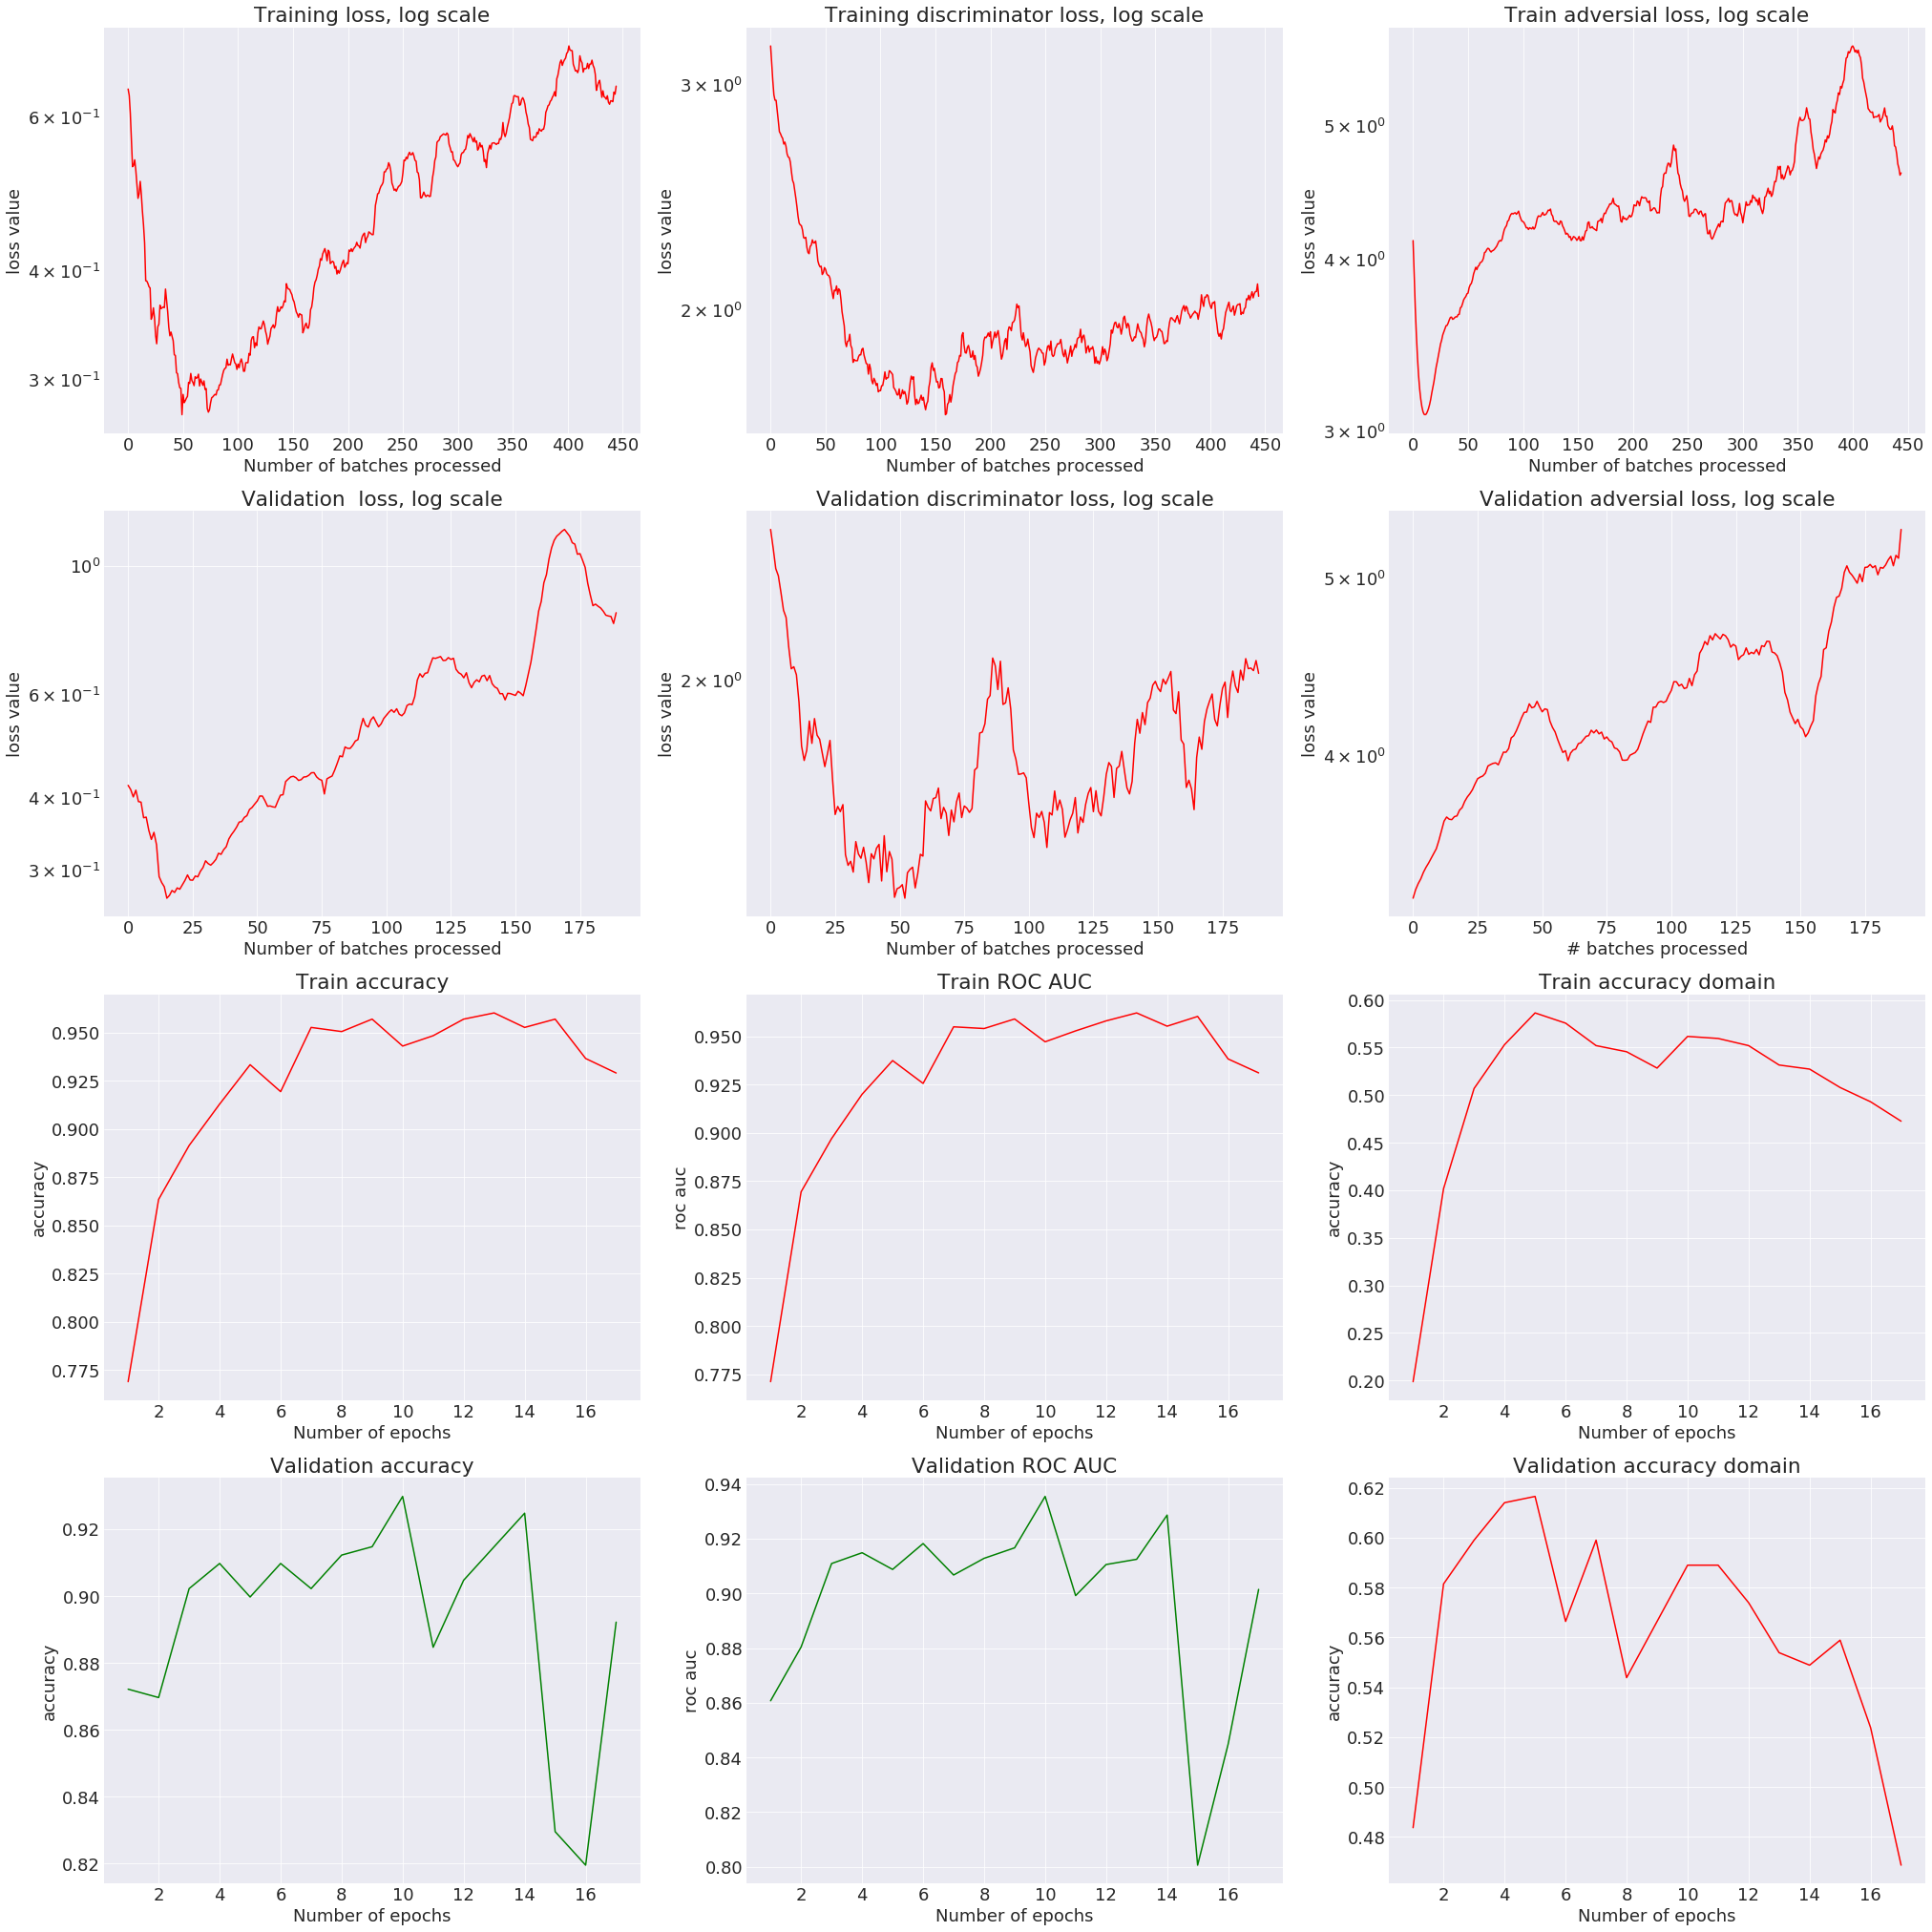

In [17]:
device = 'cuda:1' if torch.cuda.is_available() else 'cpu'
encoder.to(device)
disc.to(device)
clf.to(device)

lambda_initial = 1e-4
lambda_final = 1e-1

max_step = 300
lambda_step = (lambda_final-lambda_initial) / max_step

learning_rate_enc = 7e-4
betas_enc = (0.9,0.999)
learning_rate_disc = 5e-4
betas_disc = (0.9,0.999)

criterion_enc_clf = nn.CrossEntropyLoss(weight=torch.tensor([1,2]).float().to(device))
criterion_disc = nn.CrossEntropyLoss(weight=torch.tensor([2,1,1,1,3,3,3,3,3,3,3,3,3,3,3,3,3,3]).float().to(device))

optimizer_enc_clf = torch.optim.Adam(list(encoder.parameters())+list(clf.parameters()), 
                                     lr=learning_rate_enc, betas=betas_enc, weight_decay=1e-4)
optimizer_disc = torch.optim.Adam(disc.parameters(), lr=learning_rate_disc, betas=betas_disc, weight_decay=1e-4)


train(encoder, disc,clf, criterion_enc_clf, criterion_disc, optimizer_enc_clf, optimizer_disc,
      train_loader, val_loader, epochs=17,
      lambda_initial=lambda_initial, lambda_step=lambda_step, max_step=max_step, disc_loop=3)

In [22]:
# torch.save(encoder.state_dict(), 'encoder_1_6_4h.pth')
# torch.save(clf.state_dict(), 'clf_1_6_4.pth')
# torch.save(disc.state_dict(), 'disc_1_6_4.pth')

In [76]:
encoder.to('cpu')
encoder.load_state_dict(torch.load('encoder_93_6_4holdout.pth',map_location='cpu'))

<All keys matched successfully>

In [77]:
disc.to('cpu')
disc.load_state_dict(torch.load('disc_93_6_4.pth',map_location='cpu'))

<All keys matched successfully>

In [78]:
clf.to('cpu')
clf.load_state_dict(torch.load('clf_93_6_4.pth',map_location='cpu'))

<All keys matched successfully>

In [79]:
device = 'cuda:2' if torch.cuda.is_available() else 'cpu'
encoder.to(device)
disc.to(device)
clf.to(device)
encoder.eval()
clf.eval()
disc.eval()
with torch.no_grad():
    pred = np.array([])
    gt = np.array([])
    for batch_no, (X, y, domain) in tqdm(enumerate(test_loader), total=len(test_loader)):
        X = X.to(device)
        latent, _= encoder(X) 
        pred_logits_clf = clf(latent)
        batch_pred = np.argmax(pred_logits_clf.cpu().numpy(), axis=1)
        pred = np.append(pred, batch_pred)
        batch_y = y.cpu().numpy()
        gt = np.append(gt, batch_y) 
    acc = accuracy_score(gt, pred)
    roc = roc_auc_score(gt, pred)
    print('Accuracy on holdout set {:.3}'.format(acc))
    print('ROC-AUC on holdout set {:.3}'.format(roc))

100%|██████████| 2/2 [00:32<00:00, 16.03s/it]

Accuracy on holdout set 0.948
ROC-AUC on holdout set 0.948


In [65]:
fcd_15 = MriClassification(sample='pirogov', prefix='fcd', ignore_missing=True,data_type = 'img',
                         image_path= '/home/datasets/fcd_classification_bank',
                         targets_path= '../targets/targets_fcd_bank.csv')
test_loader_15 = torch.utils.data.DataLoader(fcd_15, batch_size=30, 
                             num_workers=0, drop_last=False, collate_fn=default_collate, shuffle=False)

  0%|          | 0/15 [00:00<?, ?it/s]

Assembling data for:  pirogov  sample.


100%|██████████| 15/15 [00:02<00:00,  6.67it/s]


In [66]:
device = 'cuda:2' if torch.cuda.is_available() else 'cpu'
encoder.to(device)
disc.to(device)
clf.to(device)
encoder.eval()
clf.eval()
disc.eval()
with torch.no_grad():
    pred = np.array([])
    gt = np.array([])
    for batch_no, (X, y, domain) in tqdm(enumerate(test_loader_15), total=len(test_loader_15)):
        X = X.to(device)
        latent, _= encoder(X) 
        pred_logits_clf = clf(latent)
        batch_pred = np.argmax(pred_logits_clf.cpu().numpy(), axis=1)
        pred = np.append(pred, batch_pred)
        batch_y = y.cpu().numpy()
        gt = np.append(gt, batch_y) 
    acc = accuracy_score(gt, pred)
    print('Accuracy on pirogov set with FCD and gt mask {:.3}'.format(acc))
    print('Prediction', pred)

100%|██████████| 1/1 [00:12<00:00, 12.68s/it]

Accuracy on pirogov set with FCD and gt mask 0.867
Prediction [0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [46]:
class Discriminator(nn.Module):
    def __init__(self, **kwargs):
        super(Discriminator, self).__init__()

        self.disc = nn.ModuleDict({
            '1_convx': nn.Conv3d(in_channels=kwargs['c_in'],
                              out_channels=kwargs['c_out'],
                              kernel_size=(kwargs['conv_k'], 1, 1),
                              stride=(kwargs['conv_s'],1,1),
                              padding=(kwargs['conv_pad'],0,0),
                          ),
            '2_convy': nn.Conv3d(in_channels=kwargs['c_out'],
                              out_channels=kwargs['c_out'],
                              kernel_size=(1, kwargs['conv_k'], 1),
                              stride=(1,kwargs['conv_s'],1),
                              padding=(0,kwargs['conv_pad'],0),
                          ),
            '3_convz': nn.Conv3d(in_channels=kwargs['c_out'],
                              out_channels=kwargs['c_out'],
                              kernel_size=(1, 1, kwargs['conv_k']),
                              stride=(1,1,kwargs['conv_s']),
                              padding=(0,0,kwargs['conv_pad']),
                          ),
            '4_flat': nn.Flatten(),
            '5_l1': nn.Linear(kwargs['l_in'], kwargs['l_out'])
        })

        if kwargs['batch_norm']:
            self.disc.update({'6_batch_norm': nn.BatchNorm1d(kwargs['l_out'])})
        if kwargs['act'] == 'l_relu':
            self.disc.update({'7_act': nn.LeakyReLU()})
            self.init_gain = nn.init.calculate_gain('leaky_relu', 0.01)
        else:
            self.disc.update({'7_act': nn.ReLU()})
            self.init_gain = nn.init.calculate_gain('relu')
        self.disc.update({'8_drop': nn.Dropout(kwargs['p_drop'])})
        self.disc.update({'9_l_f': nn.Linear(kwargs['l_out'], kwargs['n_domains'])})
        
        self.init_weights()
        
    def init_weights(self):
        for key, m in self.disc.items():
            if hasattr(m, 'weight') and m.weight.dim() > 1:
                nn.init.xavier_uniform_(m.weight.data, gain=self.init_gain)
                nn.init.constant_(m.bias.data, 0)

    def forward(self, x):
        for key, module in sorted(self.disc.items()):
            x = module(x)
            if key == '8_drop':
                b = x
        return x, b

In [47]:
disc = Discriminator(**discriminator_kwargs)
disc.to('cpu')
disc.load_state_dict(torch.load('disc_93_6_4.pth',map_location='cpu'))

<All keys matched successfully>

In [48]:
class Classificator(nn.Module):
    def __init__(self, **kwargs):
        super(Classificator, self).__init__()
        self.clf = nn.ModuleDict({
            '1_convx': nn.Conv3d(in_channels=kwargs['c_in'],
                              out_channels=kwargs['c_out'],
                              kernel_size=(kwargs['conv_k'], 1, 1),
                              stride=(kwargs['conv_s'],1,1),
                              padding=(kwargs['conv_pad'],0,0),
                          ),
            '2_convy': nn.Conv3d(in_channels=kwargs['c_out'],
                              out_channels=kwargs['c_out'],
                              kernel_size=(1, kwargs['conv_k'], 1),
                              stride=(1,kwargs['conv_s'],1),
                              padding=(0,kwargs['conv_pad'],0),
                          ),
            '3_convz': nn.Conv3d(in_channels=kwargs['c_out'],
                              out_channels=kwargs['c_out'],
                              kernel_size=(1, 1, kwargs['conv_k']),
                              stride=(1,1,kwargs['conv_s']),
                              padding=(0,0,kwargs['conv_pad']),
                          ),
            '4_flat': nn.Flatten(),
            '5_l1': nn.Linear(kwargs['l_in'], kwargs['l_out'])
        })

        if kwargs['batch_norm']:
            self.clf.update({'6_batch_norm': nn.BatchNorm1d(kwargs['l_out'])})
        if kwargs['act'] == 'l_relu':
            self.clf.update({'7_act': nn.LeakyReLU()})
            self.init_gain = nn.init.calculate_gain('leaky_relu', 0.01)
        else:
            self.clf.update({'7_act': nn.ReLU()})
            self.init_gain = nn.init.calculate_gain('relu')
        self.clf.update({'8_drop': nn.Dropout(kwargs['p_drop'])})
        self.clf.update({'9_l_f': nn.Linear(kwargs['l_out'], kwargs['n_class'])})
        
        self.init_weights()
        
    def init_weights(self):
        for key, m in self.clf.items():
            if hasattr(m, 'weight') and m.weight.dim() > 1:
                nn.init.xavier_uniform_(m.weight.data, gain=self.init_gain)
                nn.init.constant_(m.bias.data, 0)

    def forward(self, x):
        for key, module in sorted(self.clf.items()):
            x = module(x)
            if key == '8_drop':
                b = x
        return x, b

In [49]:
clf = Classificator(**classificator_kwargs)
clf.to('cpu')
clf.load_state_dict(torch.load('clf_93_6_4.pth',map_location='cpu'))

<All keys matched successfully>

In [50]:
all_loader = torch.utils.data.DataLoader(fcd_data, batch_size=30, 
                             num_workers=0, drop_last=False, collate_fn=default_collate, shuffle=False)
latent_e = []
latent_d = []
latent_c = []
encoder.eval()
encoder.to(device)
disc.eval()
clf.eval()
disc.to(device)
clf.to(device)
with torch.no_grad():
    for batch_no, (X, y, domain) in tqdm(enumerate(all_loader), total=len(all_loader)):
        X = X.to(device)
        l, _= encoder(X)
        _, b_d = disc(l)
        _, b_c = clf(l)
        l = nn.Flatten()(l)
        latent_e.append(l.cpu().numpy())
        latent_d.append(b_d.cpu().numpy())
        latent_c.append(b_c.cpu().numpy())
latent_e = np.concatenate(latent_e,axis=0)
latent_d = np.concatenate(latent_d,axis=0)
latent_c = np.concatenate(latent_c,axis=0)

100%|██████████| 47/47 [11:34<00:00, 14.78s/it]


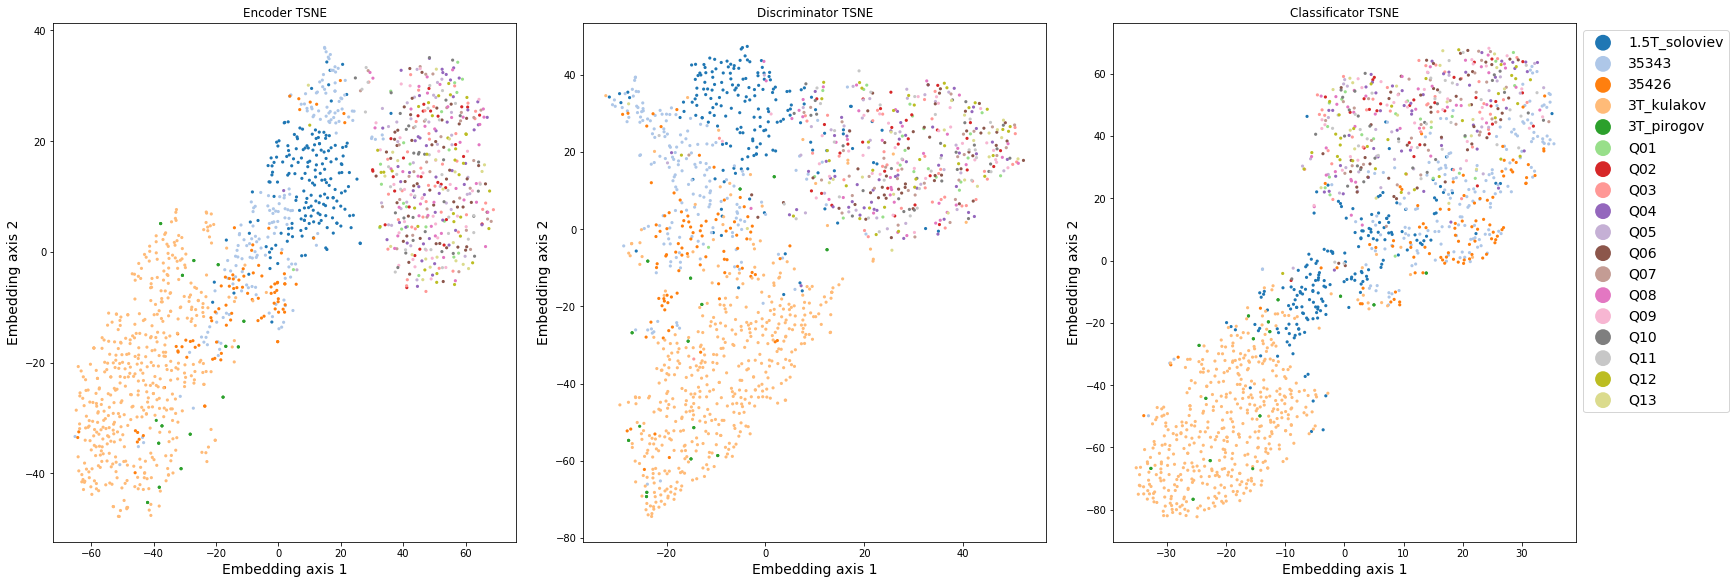

In [51]:
tsne = tsne_plot(latent_e, latent_d,latent_c, fcd_data.scan, fcd_data.scan_keys)

In [16]:
all_loader = torch.utils.data.DataLoader(fcd_data, batch_size=35, 
                             num_workers=0, drop_last=False, shuffle=False)
pca = PCA(n_components=35)
pca_data = np.empty((0,35))
device = 'cuda:1' if torch.cuda.is_available() else 'cpu'
for batch_no, (X, y, domain) in tqdm(enumerate(all_loader), total=len(all_loader)):
        X = X.to(device)
        X = nn.Flatten()(X)
        Z = pca.fit_transform(X.cpu().numpy())
        pca_data = np.append(pca_data,Z, axis=0)


  0%|          | 0/40 [00:00<?, ?it/s]
Exception in thread Thread-5:
Traceback (most recent call last):
  File "/usr/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/home/.local/lib/python3.5/site-packages/tqdm/_monitor.py", line 62, in run
    for instance in self.tqdm_cls._instances:
  File "/usr/lib/python3.5/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

 98%|█████████▊| 39/40 [14:53<00:22, 22.91s/it]


ValueError: n_components=35 must be between 0 and min(n_samples, n_features)=23 with svd_solver='full'